# <b> Flight Delay Prediction </b>

## <b> Importing libraries <b/>

In [1122]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox, kstest, f_oneway

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures

## <b> Loading datasets </b>

In [1123]:
# Main given dataset

main_df = pd.read_csv('./assets/dataset_SCL.csv', low_memory=False)
main_df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [1124]:
# City - continents mapper. New dataset to map cities with continents

continents_df = pd.read_csv('./assets/CityCountryContinent.csv', encoding='latin-1')
continents_df = continents_df[["Continent", "Country", "City"]].drop_duplicates(subset="City", keep='first')
continents_df.head()

,Continent,Country,City
0,Europe,ITALY,Roma
1,South America,URUGUAY,Montevideo
2,South America,CHILE,Santa Cruz
3,South America,ARGENTINA,San Juan
4,South America,BOLIVIA,La Paz


## <b> Data Cleaning - Data Quality Checks </b>

In [1125]:
# Removing commas from main_df SIGLADES field so it can be joined with the Continent Dataset

main_df["SIGLADES"] = main_df["SIGLADES"].apply(lambda x: x.split(',')[0])

In [1126]:
# Add Continents to main_df

df = main_df.merge(continents_df, how='inner', left_on="SIGLADES", right_on="City")

# No data loss
if len(df) != len(main_df):
    raise ImportError

In [1127]:
# Checking Nulls

df.isnull().sum()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
Continent    0
Country      0
City         0
dtype: int64

In [1128]:
# OBS: One field with null value. Probably not that important

df[df["Vlo-O"].isnull()]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,Continent,Country,City
19847,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,...,1,2017,Jueves,I,Latin American Wings,Santiago,Lima,South America,PERU,Lima


In [1129]:
# Checking duplications

df.duplicated().sum()

0

In [1130]:
# Reviewing column types to see if there is any change needed.

df.dtypes

Fecha-I      object
Vlo-I        object
Ori-I        object
Des-I        object
Emp-I        object
Fecha-O      object
Vlo-O        object
Ori-O        object
Des-O        object
Emp-O        object
DIA           int64
MES           int64
AÑO           int64
DIANOM       object
TIPOVUELO    object
OPERA        object
SIGLAORI     object
SIGLADES     object
Continent    object
Country      object
City         object
dtype: object

In [1131]:
# Changing date column types to datetime

df["Fecha-I"] = pd.to_datetime(df["Fecha-I"])
df["Fecha-O"] = pd.to_datetime(df["Fecha-O"])
df.dtypes

Fecha-I      datetime64[ns]
Vlo-I                object
Ori-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                object
Ori-O                object
Des-O                object
Emp-O                object
DIA                   int64
MES                   int64
AÑO                   int64
DIANOM               object
TIPOVUELO            object
OPERA                object
SIGLAORI             object
SIGLADES             object
Continent            object
Country              object
City                 object
dtype: object

## <b> PROCEDURE </b>
For every question:  
- I'll code and make my calculations first  
- At the end I'll leave my final answer to the question 
- Every cell will have some comments to explain what I am doing and why

## <b> 1. How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this? </b>

In [1132]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,Continent,Country,City
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,1,2017,Domingo,I,American Airlines,Santiago,Miami,North America,UNITED STATES,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,1,2017,Lunes,I,American Airlines,Santiago,Miami,North America,UNITED STATES,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,1,2017,Martes,I,American Airlines,Santiago,Miami,North America,UNITED STATES,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,1,2017,Miercoles,I,American Airlines,Santiago,Miami,North America,UNITED STATES,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,1,2017,Jueves,I,American Airlines,Santiago,Miami,North America,UNITED STATES,Miami


In [1133]:
# How many flights with delays do we have?

delays_pct = len(df[df["Fecha-I"] < df["Fecha-O"]])/len(df)
print('About {}% of the flights experienced some kind of delay.'.format(round(100*delays_pct, 2)))

About 66.72% of the flights experienced some kind of delay.


In [1134]:
# Scheduled vs operating? If they are diffferent it could directly affect the delay.
# Note: they might be highly correlated between them.

airline_diff = len(df[df["Emp-I"] != df["Emp-O"]])/len(df)
airline_diff_delay = len(df[(df["Des-I"] != df["Des-O"]) & (df["Fecha-I"] < df["Fecha-O"])])/len(df[df["Des-I"] != df["Des-O"]])

flight_number_diff = len(df[df["Vlo-I"] != df["Vlo-O"]])/len(df)
flight_number_diff_delay = len(df[(df["Vlo-I"] != df["Vlo-O"]) & (df["Fecha-I"] < df["Fecha-O"])])/len(df[df["Vlo-I"] != df["Vlo-O"]])

destination_diff = len(df[df["Des-I"] != df["Des-O"]])/len(df)
destination_diff_delay = len(df[(df["Emp-I"] != df["Emp-O"]) & (df["Fecha-I"] < df["Fecha-O"])])/len(df[df["Emp-I"] != df["Emp-O"]])

print('Operating and scheduled airlines are different for {}% of the flights. {}% of them were delayed.'.format(round(100*airline_diff, 2), round(100*airline_diff_delay, 2)))
print('Operating and scheduled flight number are different for {}% of the flights. {}% of them were delayed.'.format(round(100*flight_number_diff, 2), round(100*flight_number_diff_delay, 2)))
print('Operating and scheduled destinations are different for {}% of the flights. {}% of them were delayed.'.format(round(100*destination_diff, 2), round(100*destination_diff_delay, 2)))

Operating and scheduled airlines are different for 27.37% of the flights. 78.57% of them were delayed.
Operating and scheduled flight number are different for 6.63% of the flights. 77.98% of them were delayed.
Operating and scheduled destinations are different for 0.04% of the flights. 71.5% of them were delayed.


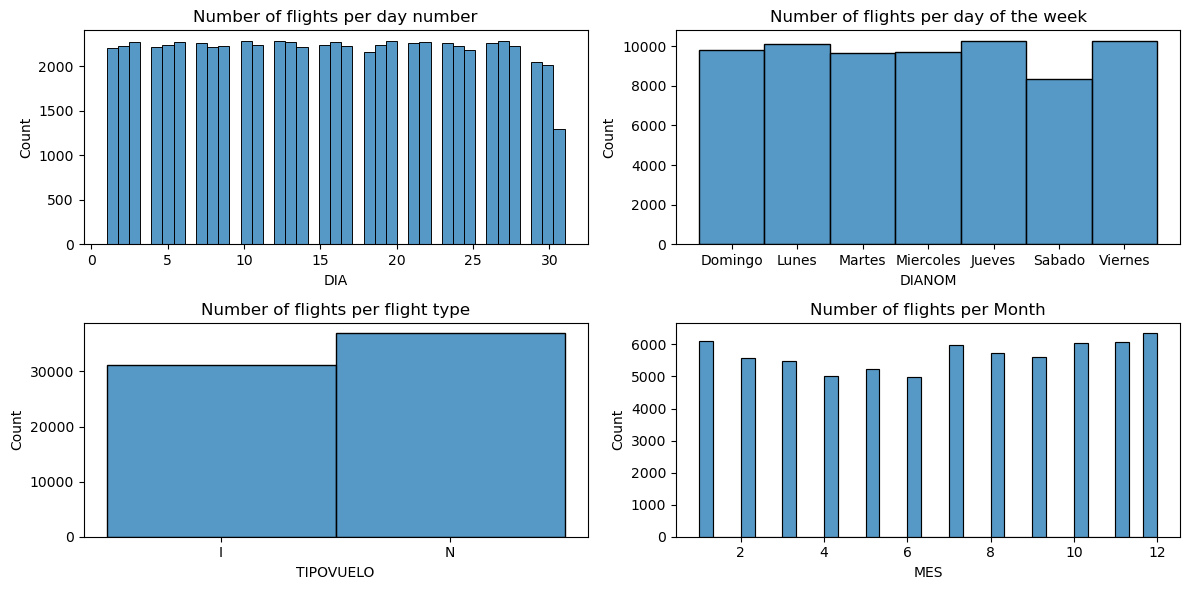

In [1137]:
# Understand how the number of flights are distributed across different dimensions

f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(221)
sns.histplot(df["DIA"])
ax1.set_title('Number of flights per day number')

ax2 = f.add_subplot(222)
sns.histplot(df["DIANOM"])
ax2.set_title('Number of flights per day of the week')

ax3 = f.add_subplot(223)
sns.histplot(df["TIPOVUELO"])
ax3.set_title('Number of flights per flight type')

ax4 = f.add_subplot(224)
sns.histplot(df["MES"])
ax4.set_title('Number of flights per Month')

plt.tight_layout()

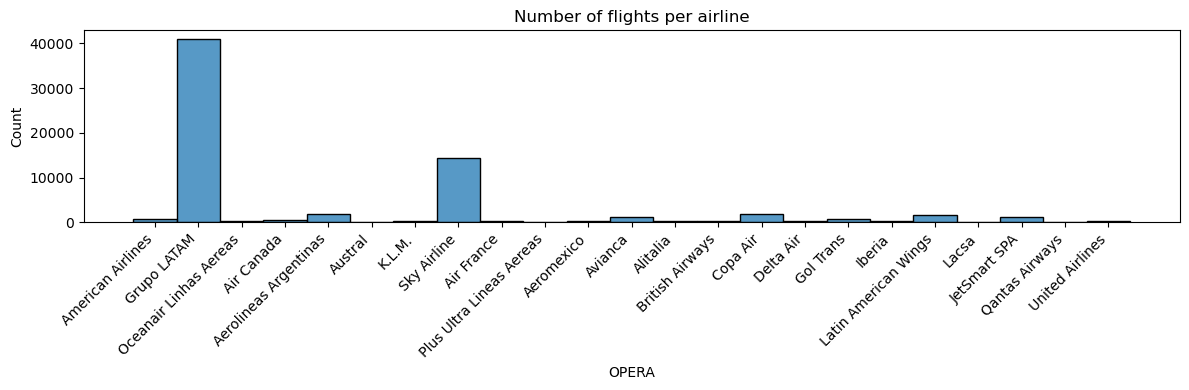

In [1138]:
# Number of flights are somehow evenly distributed across airlines?

f = plt.figure(figsize=(12,4))

ax1 = f.add_subplot(111)
sns.histplot(df["OPERA"])
ax1.set_title('Number of flights per airline')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

In [1139]:
# From previous cell: clear difference between LATAM, Sky Airline and the others
# How many flights are concentrated between Grupo LATAM and Sky Airline?

latam_skyair_share = len(df[(df["OPERA"] == 'Grupo LATAM') | (df["OPERA"] == 'Sky Airline')])/len(df)
print('Group LATAM and SKy Airline operates {}% of the flights.'.format(round(100*latam_skyair_share, 2)))

Group LATAM and SKy Airline operates 80.92% of the flights.


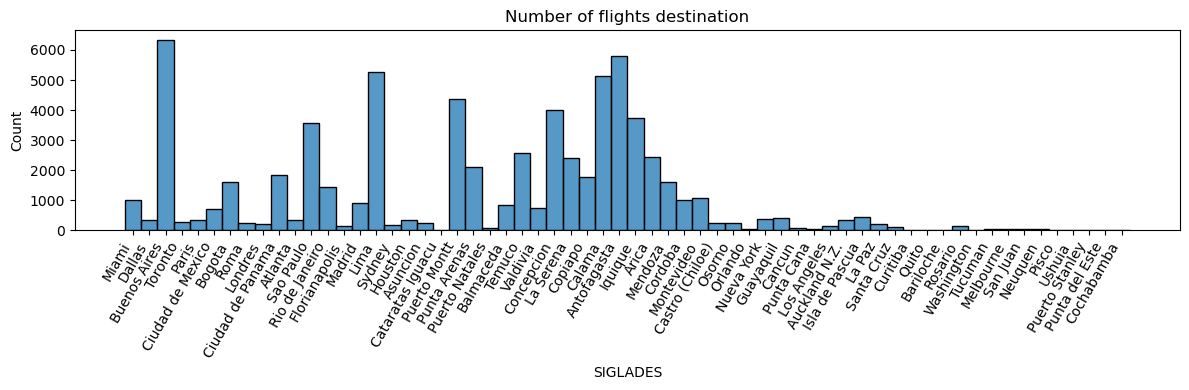

In [1140]:
# What about number of flights per destination?

f = plt.figure(figsize=(12,4))

ax1 = f.add_subplot(111)
sns.histplot(df["SIGLADES"])
ax1.set_title('Number of flights destination')
plt.xticks(rotation=60, ha='right')

plt.tight_layout()

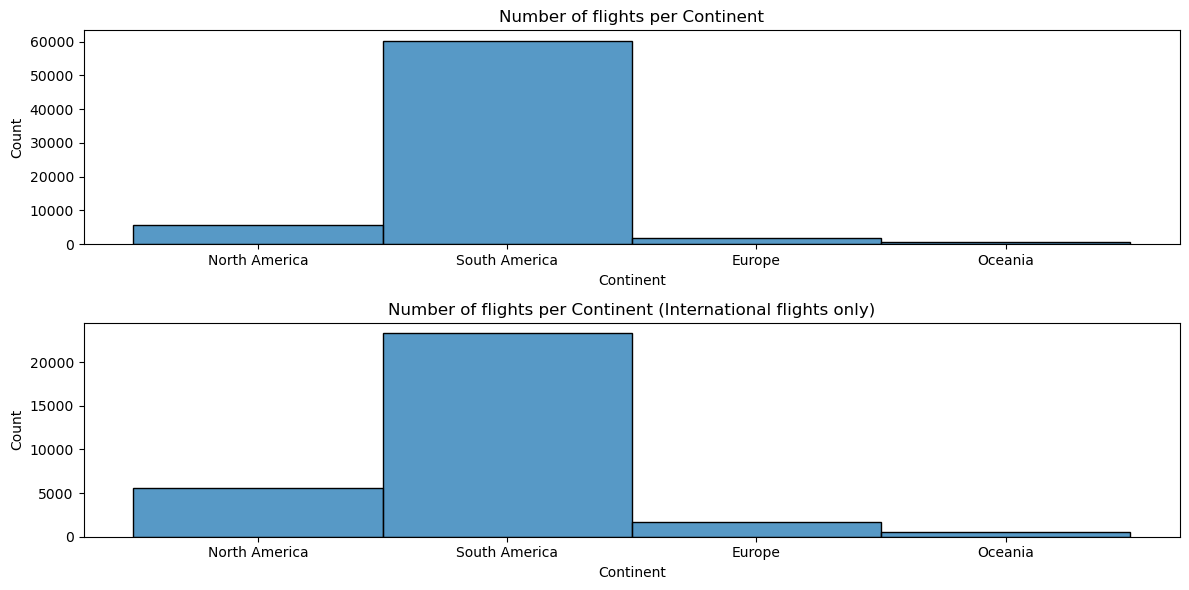

In [1141]:
# We have lot of destinations, maybe per continent will give us a better understanding on how the number of flights are distributed.
# Also, lot of destinations with a small number of flights.

f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(211)
sns.histplot(df["Continent"])
ax1.set_title('Number of flights per Continent')

ax2 = f.add_subplot(212)
sns.histplot(df[df["TIPOVUELO"] == 'I']["Continent"])
ax2.set_title('Number of flights per Continent (International flights only)')

plt.tight_layout()

In [1142]:
# Share of southamerican flights for international flights

sa_flights_share = len(df[df["Continent"] == 'South America'])/len(df)
sa_flights_share_int = len(df[(df["TIPOVUELO"] == 'I') & (df["Continent"] == 'South America')])/len(df[df["TIPOVUELO"] == 'I'])
print('About {}% of all flights are with a South American country as destination.'.format(round(100*sa_flights_share, 2)))
print('South America as a destination takes {}% of all International flights.'.format(round(100*sa_flights_share_int, 2)))

About 88.42% of all flights are with a South American country as destination.
South America as a destination takes 74.72% of all International flights.


## <b> ANSWER - Insights</b>
### <b> Descriptive analysis </b>

- About 66.72% of the flights experienced some kind of delay.
- Operating and scheduled airlines are different for 27.37% of the flights. 78.57% of them were delayed.
- Operating and scheduled flight number are different for 6.63% of the flights. 77.98% of them were delayed.
- Operating and scheduled destinations are different for 0.04% of the flights. 71.5% of them were delayed.
- LATAM and SKy Airline operates 80.92% of the flights.
- About 88.42% of all flights are with a South American country as destination.
- South America as a destination takes 74.72% of all International flights.
- There are some clear seasonal trends:
    - More flights around July and January
    - Less flights at the end of the month

## <b> 2. Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv. </b>

### <b> high_season </b>
Field description: 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.  
ASSUMPTION: Intervals are inclusive.

In [1143]:
# OBS: DIA, MES, ANO given are from Fecha-O. I'll decompose Fecha-I in day, month and year to be able to use this not just for this table (just 2017) but for a table with more years as well.

def high_season(row):
    
    month_day = row["Fecha-I"].strftime('%m-%d')

    if month_day >= '12-15' or month_day <= '03-03':
        return 1
    elif month_day >= '07-15' and month_day <= '07-31':
        return 1
    elif month_day >= '09-11' and month_day <= '09-30':
        return 1
    else: return 0

df["high_season"] = df.apply(high_season, axis=1)


### <b> min_diff </b>
Field description: difference in minutes between Date-O and Date-I.  
OBS: I'll keep the sign of the difference

In [1144]:
df["min_diff"] = (df["Fecha-O"] - df["Fecha-I"]).astype('timedelta64[m]')

### <b> delay_15 </b>
Field description: 1 if min_diff > 15, 0 if not.

In [1145]:
df["delay_15"] = np.where(df["min_diff"] > 15, 1, 0)

### <b> period_day </b>
Field description: morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based on Date-I.  
ASSUMPTION: Intervals are inclusive.

In [1146]:
def period_day(row):
    
    daytime = row["Fecha-I"].strftime('%H:%M')
    
    if daytime >= '05:00' and daytime < '12:00':
        return 'morning'
    elif daytime >= '12:00' and daytime < '19:00':
        return 'afternoon'
    else:
        return 'night'

df["period_day"] = df.apply(period_day, axis=1)

In [1149]:
# Check new fields added

df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,OPERA,SIGLAORI,SIGLADES,Continent,Country,City,high_season,min_diff,delay_15,period_day
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,North America,UNITED STATES,Miami,1,3.0,0,night
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,North America,UNITED STATES,Miami,1,9.0,0,night
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,North America,UNITED STATES,Miami,1,9.0,0,night
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,North America,UNITED STATES,Miami,1,3.0,0,night
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,North America,UNITED STATES,Miami,1,-2.0,0,night


In [1148]:
# Save dataframe in csv

df.to_csv('synthetic_features.csv')

## <b> 3. What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight? What variables would you expect to have the most influence in predicting delays? </b>

### <b> First let's understand the delay (min_diff) distribution </b>

In [1023]:
df["min_diff"].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    68206.000000
mean         9.110855
std         19.313387
min        -14.000000
1%         -11.000000
5%          -6.000000
10%         -4.000000
25%         -1.000000
50%          4.000000
75%         12.000000
90%         26.000000
95%         43.000000
99%        102.000000
max        161.000000
Name: min_diff, dtype: float64

Text(0.5, 1.0, 'Delay in minutes histogram')

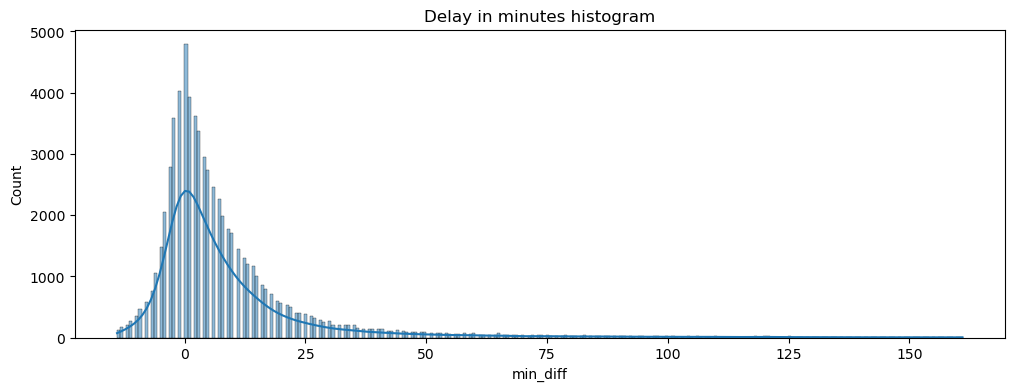

In [801]:
f = plt.figure(figsize=(12,4))

ax1 = f.add_subplot(111)
sns.histplot(df["min_diff"], kde=True)
ax1.set_title('Delay in minutes histogram')

OBS: Highly right skewed distribution. No normal.

### <b> Outliers analysis </b>
It seems there are some extreme values that could affect our predictions and understanding of the data. Unexpected events can happen and need to be removed.

Text(0.5, 1.0, 'Box plot delay in minutes')

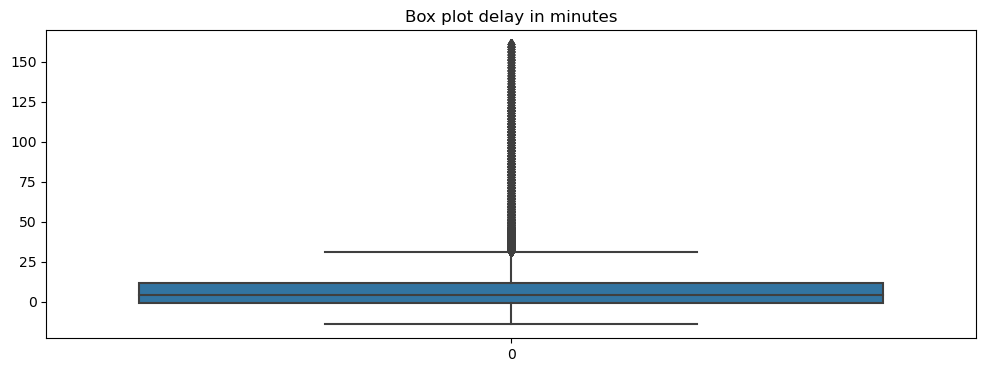

In [1150]:
# Boxplot to understand better the distribution

f = plt.figure(figsize=(12,4))

ax1 = f.add_subplot(111)
sns.boxplot(df["min_diff"])
ax1.set_title('Box plot delay in minutes')

In [803]:
# First attempt to remove outliers using interquartile range

first_quartile = np.percentile(df["min_diff"], 25)
third_quartile = np.percentile(df["min_diff"], 75)
IQR = third_quartile - first_quartile
lower_bound = first_quartile - 1.5*IQR
upper_bound = third_quartile + 1.5*IQR

# Proportion of data to be removed by using this method
print(len(df[(df["min_diff"] < lower_bound) | (df["min_diff"] > upper_bound)])/len(df))

0.07621030407882004


OBS: Removing 7-8% of data seemes to much...

Text(0.5, 1.0, 'Box plot transformed delay')

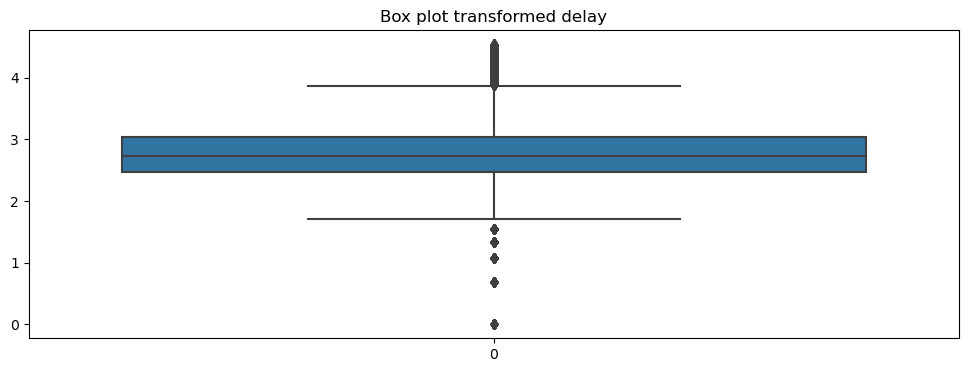

In [1154]:
# Second attempt to remove outliers transforming the data using boxcox

df["boxcox_min_diff"] = boxcox(df["min_diff"] + -1*(df["min_diff"].min()) + 1, alpha=0.05)[0]

#Box plot to visualize distribution of transformed delay
f = plt.figure(figsize=(12,4))

ax1 = f.add_subplot(111)
sns.boxplot(df["boxcox_min_diff"])
ax1.set_title('Box plot transformed delay')

In [1155]:
first_quartile = np.percentile(df["boxcox_min_diff"], 25)
third_quartile = np.percentile(df["boxcox_min_diff"], 75)
IQR = third_quartile - first_quartile
lower_bound = first_quartile - 1.5*IQR
upper_bound = third_quartile + 1.5*IQR

df_wo_outliers = df[(df["boxcox_min_diff"] > lower_bound) & (df["boxcox_min_diff"] < upper_bound)].reset_index()

print('Outliers removed: {}%.'.format(round(100 - 100*len(df_wo_outliers)/len(df), 2)))

#4-5% could make more sense

Outliers removed: 4.55%.


### <b> Normality test with outliers removed </b>
Check boxcox transformation and use Kolmogorov-Smirnov to check if we can transform this into a normal distribution so we can have a wider variety of tests to try.

In [1157]:
pvalue_norm = kstest(df_wo_outliers["min_diff"], 'norm').pvalue
pvalue_transformed = kstest(df_wo_outliers["boxcox_min_diff"], 'norm').pvalue

if pvalue_norm < 0.05: print('Delay in minutes does not follow a normal distribution')
else: print('Delay in minutes follows a normal distribution')

if pvalue_transformed < 0.05: print('Transformed Delay does not follow a normal distribution')
else: print('Transformed Delay in minutes follows a normal distribution')

Delay in minutes does not follow a normal distribution
Transformed Delay does not follow a normal distribution


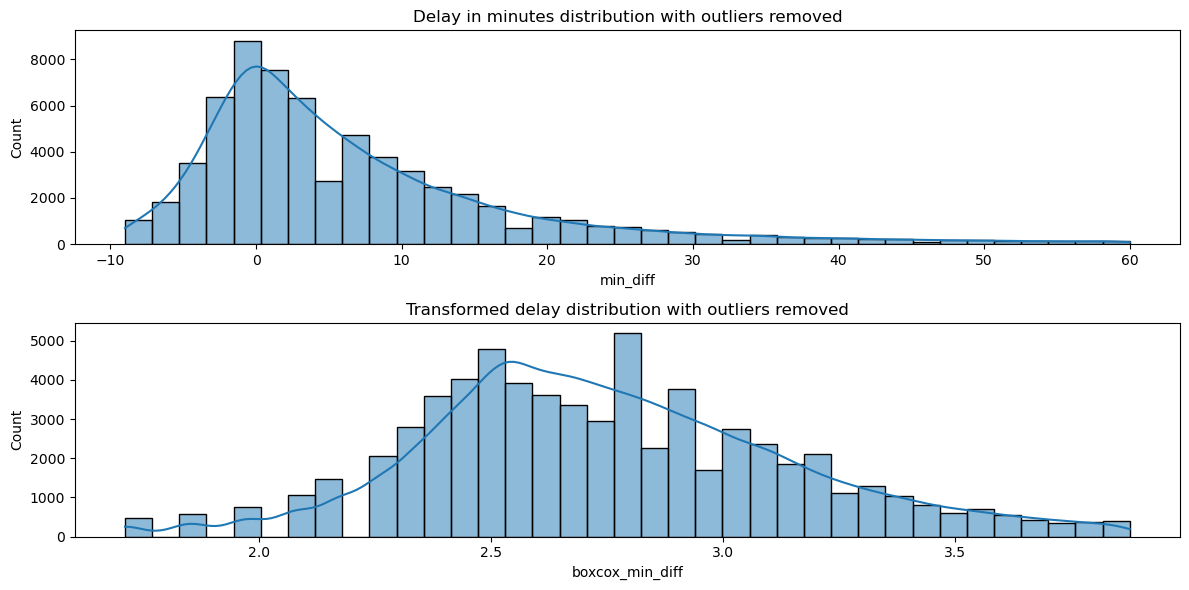

In [1158]:
n_bins = int(1 + 3.322*np.log(len(df_wo_outliers)))

f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(211)
sns.histplot(df_wo_outliers["min_diff"], kde=True, bins=n_bins)
ax1.set_title('Delay in minutes distribution with outliers removed')

ax1 = f.add_subplot(212)
sns.histplot(df_wo_outliers["boxcox_min_diff"], kde=True, bins=n_bins)
ax1.set_title('Transformed delay distribution with outliers removed')

plt.tight_layout()

### <b> Understanding correlations </b>

Text(0.5, 1.0, 'Heatmap correlations between numeric variables')

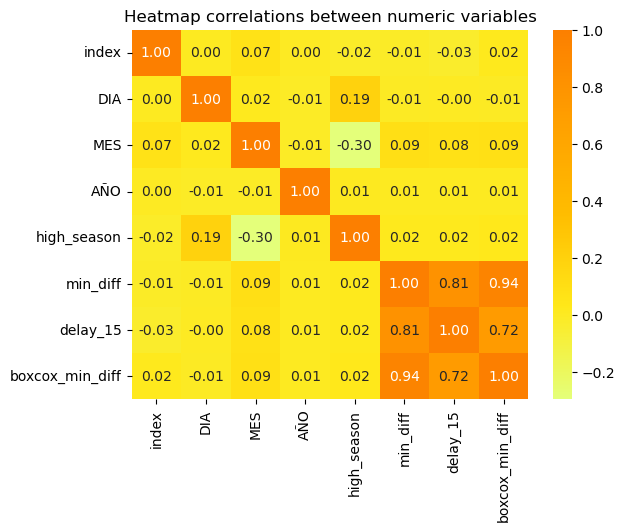

In [1170]:
# Start with general heatmap

corr = df_wo_outliers.corr(numeric_only=True)
ax = sns.heatmap(corr, cmap='Wistia', annot=True, fmt='.2f')
ax.set_title('Heatmap correlations between numeric variables')

OBS: No strong correlations. Just Month and High Season, that is expected.

In [809]:
# Function to get different statistics per dimension

def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean(),
            'stddev': group.std()}

#### <b> Delay vs Destination </b>

In [1166]:
destination_stats = df_wo_outliers["min_diff"].groupby(df_wo_outliers["SIGLADES"]).apply(get_stats).unstack()
destination_stats.sort_values("mean", ascending=False)

,min,max,count,mean,stddev
SIGLADES,,,,,
Puerto Stanley,50.0,50.0,1.0,50.000000,NaN
Ushuia,8.0,53.0,6.0,24.500000,16.670333
Quito,24.0,24.0,1.0,24.000000,NaN
Sydney,-7.0,60.0,171.0,18.631579,14.796222
Bariloche,7.0,30.0,2.0,18.500000,16.263456
...,...,...,...,...,...
Curitiba,-4.0,6.0,2.0,1.000000,7.071068
Washington,0.0,0.0,1.0,0.000000,NaN
Atlanta,-9.0,50.0,336.0,-0.038690,8.484665


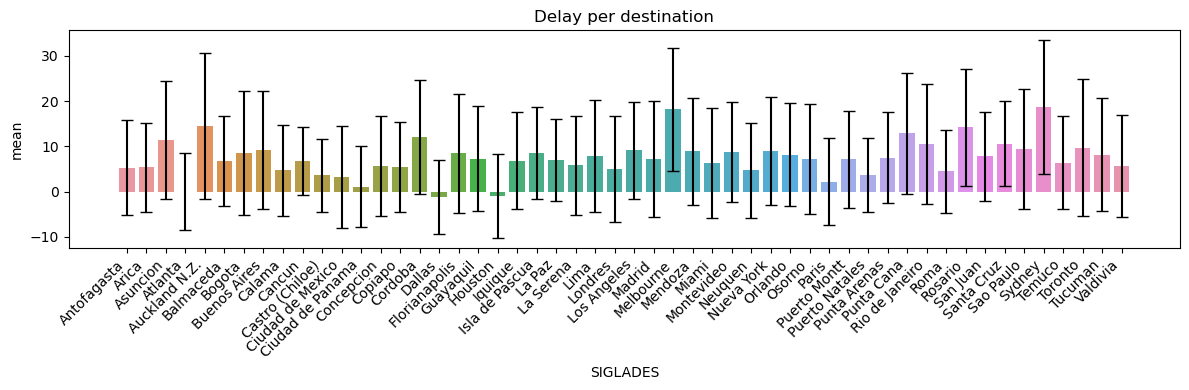

In [1171]:
# Remove from graph destinations with less than 10 flights, so it does not add noise to the visualization
destination_stats = destination_stats[destination_stats["count"] > 10]

f = plt.figure(figsize=(12, 4))

ax3 = f.add_subplot(111)
sns.barplot(x="SIGLADES", y="mean", data=destination_stats.reset_index())
plt.errorbar(x=destination_stats.index, y=destination_stats["mean"].values, yerr=destination_stats["stddev"], fmt='none', capsize=4, ecolor='black')
plt.xticks(rotation=45, ha='right')
ax3.set_title('Delay per destination')

plt.tight_layout()

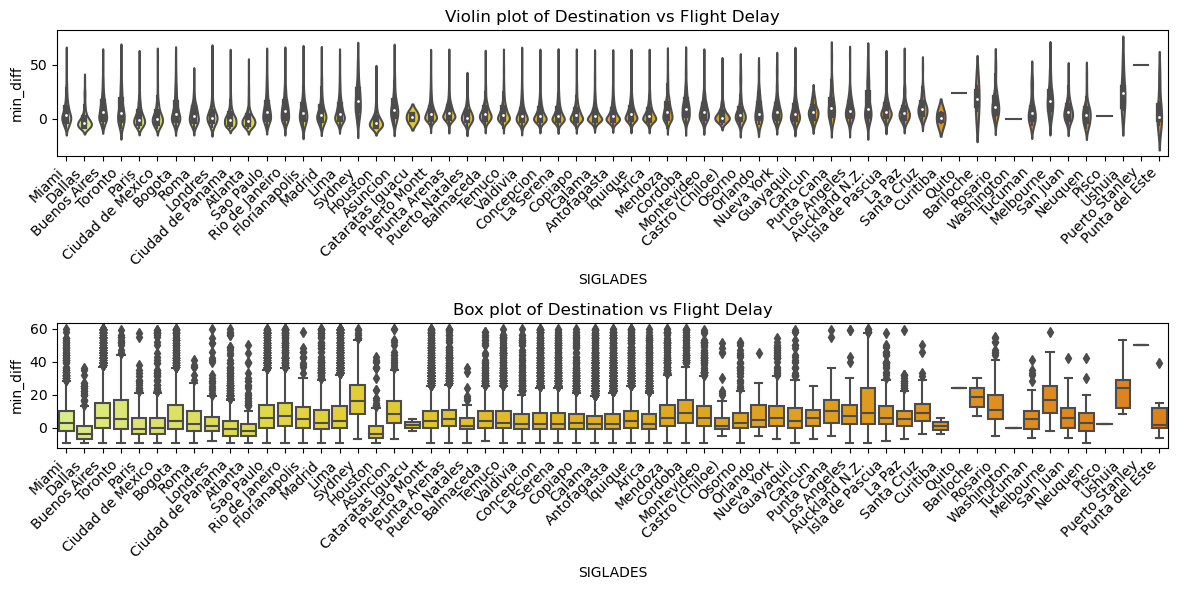

In [1172]:
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(211)
sns.violinplot(x="SIGLADES", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax1.set_title('Violin plot of Destination vs Flight Delay')
plt.xticks(rotation=45, ha='right')

ax2 = f.add_subplot(212)
sns.boxplot(x="SIGLADES", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax2.set_title('Box plot of Destination vs Flight Delay')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

OBS: There are definitely differences depending on the airport. But we don't have enough data for each airport, so it will be better to bucketize airport based on some condition. I'll use continents instead. Putting all this as dummy variables will lead to a dimensionality problem.

In [1174]:
# Get the stats not just for delay in minutes but also for this variable. It gives us a deeper understanding of the relationship with the dimension.

continent_stats = df_wo_outliers["delay_15"].groupby(df_wo_outliers["Continent"]).apply(get_stats).unstack()
continent_stats.sort_values("mean", ascending=False)

,min,max,count,mean,stddev
Continent,,,,,
Oceania,0.0,1.0,550.0,0.410909,0.492447
South America,0.0,1.0,57895.0,0.166094,0.372168
Europe,0.0,1.0,1627.0,0.135218,0.342062
North America,0.0,1.0,5032.0,0.113474,0.317203


In [813]:
continent_stats = df_wo_outliers["min_diff"].groupby(df_wo_outliers["Continent"]).apply(get_stats).unstack()
continent_stats.sort_values("mean", ascending=False)

,min,max,count,mean,stddev
Continent,,,,,
Oceania,-9.0,60.0,550.0,16.030909,15.705189
South America,-9.0,60.0,57895.0,7.111149,11.478935
Europe,-9.0,60.0,1627.0,5.505839,11.780816
North America,-9.0,60.0,5032.0,3.482114,11.166975


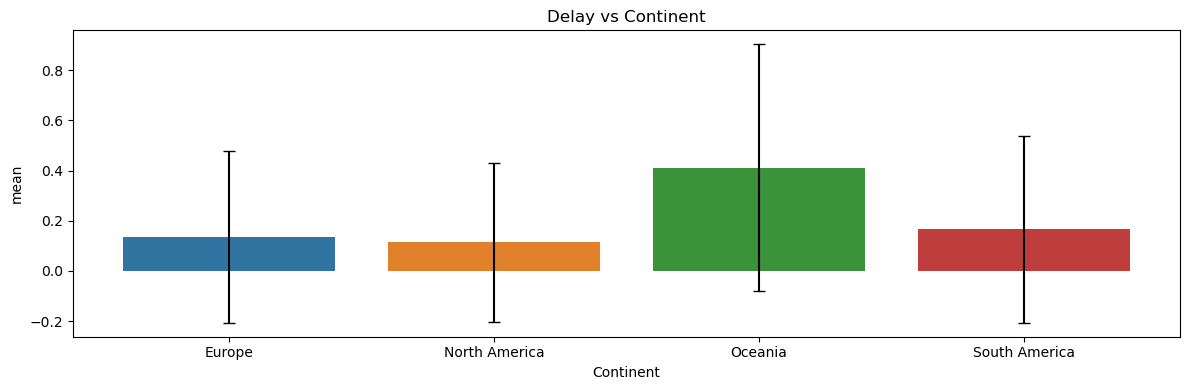

In [1173]:
f = plt.figure(figsize=(12, 4))

ax = f.add_subplot(111)
sns.barplot(x="Continent", y="mean", data=continent_stats.reset_index())
plt.errorbar(x=continent_stats.index, y=continent_stats["mean"].values, yerr=continent_stats["stddev"], fmt='none', capsize=4, ecolor='black')
ax.set_title('Delay vs Continent')

plt.tight_layout()

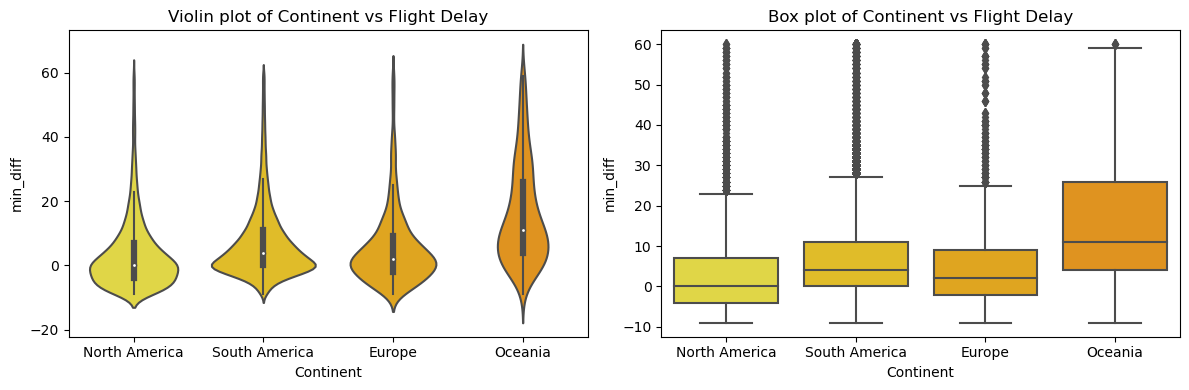

In [1175]:
f = plt.figure(figsize=(12,4))

ax1 = f.add_subplot(121)
sns.violinplot(x="Continent", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax1.set_title('Violin plot of Continent vs Flight Delay')

ax2 = f.add_subplot(122)
sns.boxplot(x="Continent", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax2.set_title('Box plot of Continent vs Flight Delay')

plt.tight_layout()

OBS: We can see clear differences in the distributions.

#### <b> Delay vs Airline </b>

In [1031]:
opera_stats = df_wo_outliers["min_diff"].groupby(df_wo_outliers["OPERA"]).apply(get_stats).unstack()
opera_stats.sort_values("mean", ascending=False)

,min,max,count,mean,stddev
OPERA,,,,,
Plus Ultra Lineas Aereas,-9.0,59.0,42.0,20.761905,19.237678
Qantas Airways,-7.0,60.0,172.0,18.552326,14.789464
Air Canada,-9.0,60.0,492.0,14.774390,17.218848
Gol Trans,-9.0,59.0,663.0,12.559578,17.000951
Latin American Wings,-9.0,60.0,1371.0,11.967907,16.347070
Austral,-9.0,47.0,68.0,8.220588,13.145393
Avianca,-9.0,60.0,1019.0,8.204122,14.557505
Aerolineas Argentinas,-9.0,60.0,1733.0,7.824582,14.327187
Grupo LATAM,-9.0,60.0,39762.0,7.341608,10.755602


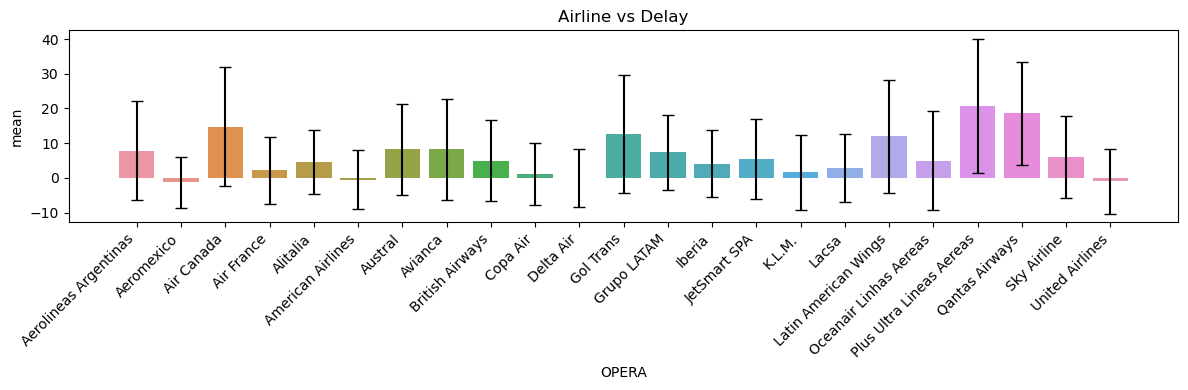

In [1176]:
f = plt.figure(figsize=(12, 4))

ax = f.add_subplot(111)
sns.barplot(x="OPERA", y="mean", data=opera_stats.reset_index())
plt.errorbar(x=opera_stats.index, y=opera_stats["mean"].values, yerr=opera_stats["stddev"], fmt='none', capsize=4, ecolor='black')
plt.xticks(rotation=45, ha='right')
ax.set_title('Airline vs Delay')

plt.tight_layout()

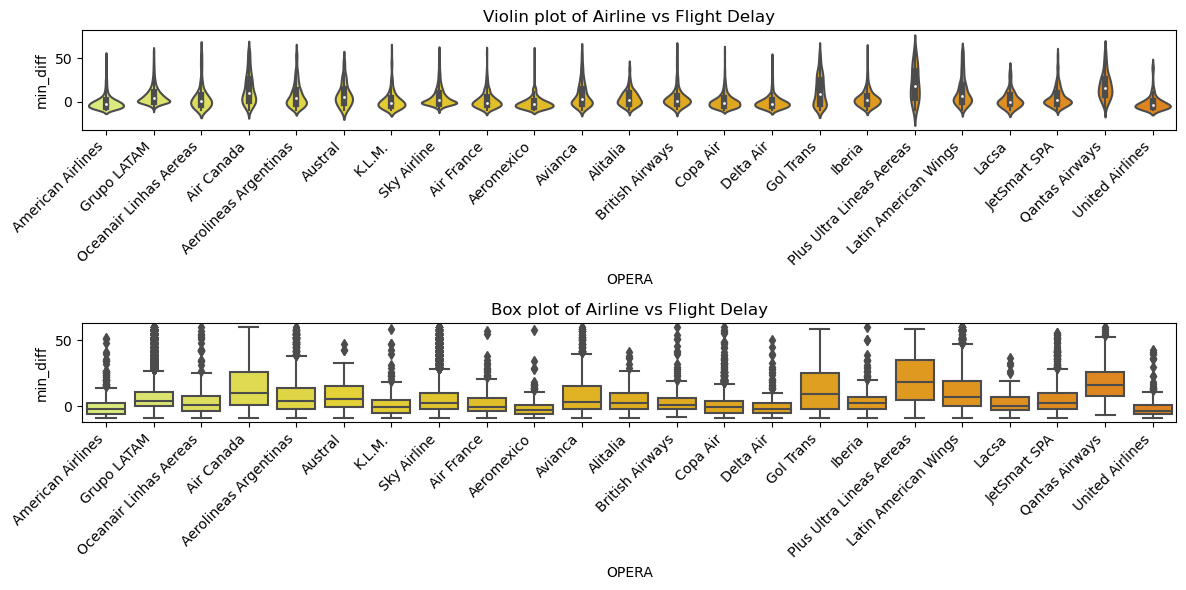

In [1177]:
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(211)
sns.violinplot(x="OPERA", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax1.set_title('Violin plot of Airline vs Flight Delay')
plt.xticks(rotation=45, ha='right')

ax2 = f.add_subplot(212)
sns.boxplot(x="OPERA", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax2.set_title('Box plot of Airline vs Flight Delay')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

In [1178]:
# Let's bucket airlines by flights count as a proxy of airline size

def flights_count_bucket(row):
    
    if row["count"] < 1000:
        return 'low'
    elif row["count"] < 10000:
        return 'medium'
    else:
        return 'high'

opera_stats["flights_count_bucket"] = opera_stats.apply(flights_count_bucket, axis=1)
df_wo_outliers = df_wo_outliers.merge(opera_stats.reset_index()[["OPERA", "flights_count_bucket"]], on="OPERA", how='inner')

In [1179]:
opera_stats = df_wo_outliers["delay_15"].groupby(df_wo_outliers["flights_count_bucket"]).apply(get_stats).unstack()
opera_stats.sort_values("mean", ascending=False)

,min,max,count,mean,stddev
flights_count_bucket,,,,,
medium,0.0,1.0,6832.0,0.195989,0.396989
low,0.0,1.0,4619.0,0.177528,0.382156
high,0.0,1.0,53653.0,0.157941,0.364689


In [1180]:
opera_stats = df_wo_outliers["min_diff"].groupby(df_wo_outliers["flights_count_bucket"]).apply(get_stats).unstack()
opera_stats.sort_values("mean", ascending=False)

,min,max,count,mean,stddev
flights_count_bucket,,,,,
high,-9.0,60.0,53653.0,7.007362,11.031779
medium,-9.0,60.0,6832.0,6.715896,13.824864
low,-9.0,60.0,4619.0,5.444468,13.816957


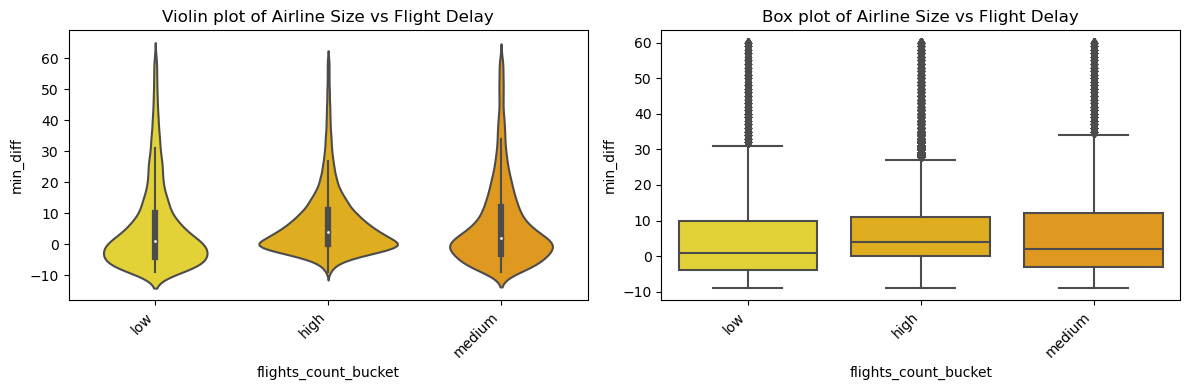

In [1181]:
f = plt.figure(figsize=(12,4))

ax1 = f.add_subplot(121)
sns.violinplot(x="flights_count_bucket", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax1.set_title('Violin plot of Airline Size vs Flight Delay')
plt.xticks(rotation=45, ha='right')

ax2 = f.add_subplot(122)
sns.boxplot(x="flights_count_bucket", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax2.set_title('Box plot of Airline Size vs Flight Delay')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

Note: It would be interesting to have more information about the airlines to categorize them. Cluster them by revenue or other factor.
Not seeing really clear and strong differences.

#### <b> Delay vs Month </b>

In [1182]:
month_stats = df_wo_outliers["min_diff"].groupby(df_wo_outliers["MES"]).apply(get_stats).unstack()
month_stats.sort_values("mean", ascending=False)

,min,max,count,mean,stddev
MES,,,,,
7,-9.0,60.0,5531.0,10.305370,13.650608
12,-9.0,60.0,6060.0,9.282508,12.773280
10,-9.0,60.0,5694.0,8.258342,12.426584
11,-9.0,60.0,5835.0,7.496315,11.676642
8,-9.0,60.0,5488.0,6.372085,11.400093
9,-9.0,60.0,5352.0,6.296525,11.254737
6,-9.0,60.0,4731.0,6.247305,11.103422
5,-9.0,60.0,5047.0,6.239746,11.275633
1,-9.0,60.0,5893.0,6.189547,10.528122


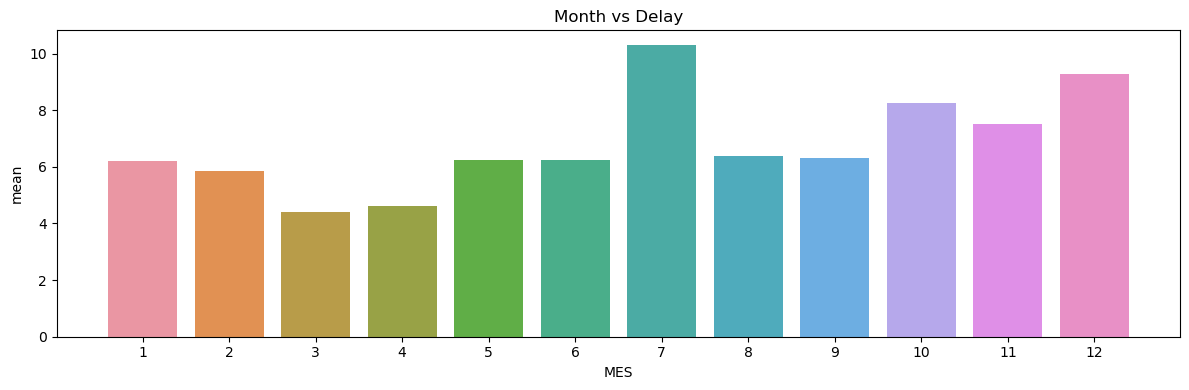

In [1183]:
f = plt.figure(figsize=(12, 4))

ax = f.add_subplot(111)
sns.barplot(x="MES", y="mean", data=month_stats.reset_index())
plt.errorbar(x=month_stats.index, y=month_stats["mean"].values, fmt='none', capsize=4, ecolor='black')
ax.set_title('Month vs Delay')

plt.tight_layout()

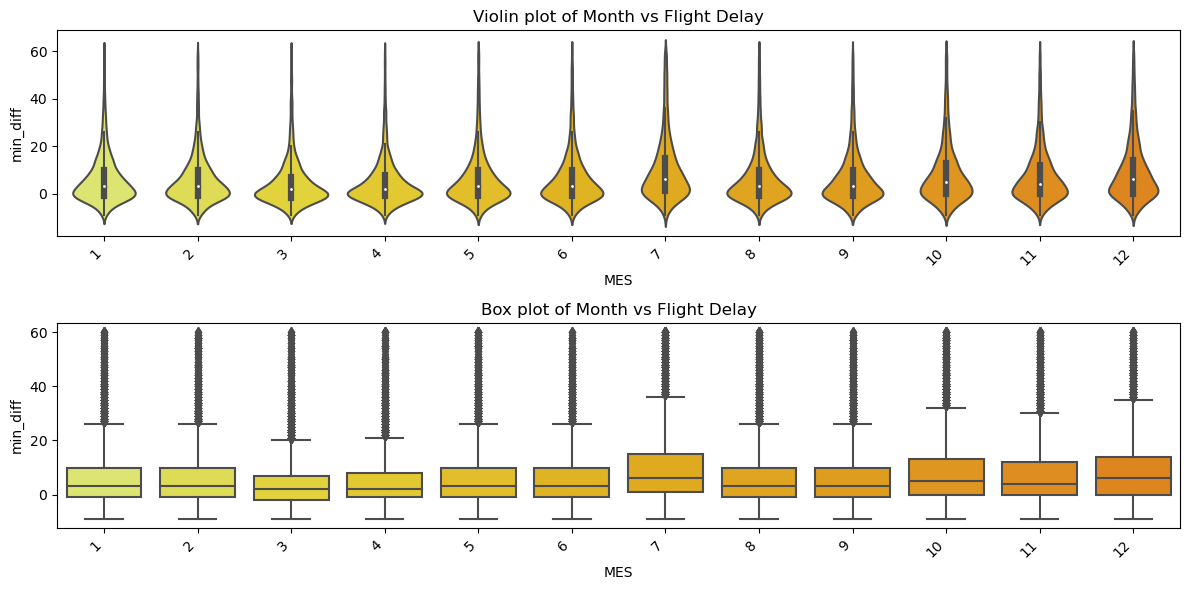

In [1184]:
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(211)
sns.violinplot(x="MES", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax1.set_title('Violin plot of Month vs Flight Delay')
plt.xticks(rotation=45, ha='right')

ax2 = f.add_subplot(212)
sns.boxplot(x="MES", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax2.set_title('Box plot of Month vs Flight Delay')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

In [1185]:
def quarter(row):
    if row["MES"] < 4:
        return 'Q1'
    elif row["MES"] < 7:
        return 'Q2'
    elif row["MES"] < 10:
        return 'Q3'
    else:
        return 'Q4'

df_wo_outliers["quarter"] = df_wo_outliers.apply(quarter, axis=1)
quarter_stats = df_wo_outliers["delay_15"].groupby(df_wo_outliers["quarter"]).apply(get_stats).unstack()
quarter_stats.sort_values("mean", ascending=False)

,min,max,count,mean,stddev
quarter,,,,,
Q4,0.0,1.0,17589.0,0.203366,0.402514
Q3,0.0,1.0,16371.0,0.184045,0.387533
Q2,0.0,1.0,14638.0,0.132532,0.339080
Q1,0.0,1.0,16506.0,0.127408,0.333440


In [1186]:
quarter_stats = df_wo_outliers["min_diff"].groupby(df_wo_outliers["quarter"]).apply(get_stats).unstack()
quarter_stats.sort_values("mean", ascending=False)

,min,max,count,mean,stddev
quarter,,,,,
Q4,-9.0,60.0,17589.0,8.358406,12.327220
Q3,-9.0,60.0,16371.0,7.676257,12.306209
Q2,-9.0,60.0,14638.0,5.698183,10.760946
Q1,-9.0,60.0,16506.0,5.507270,10.385270


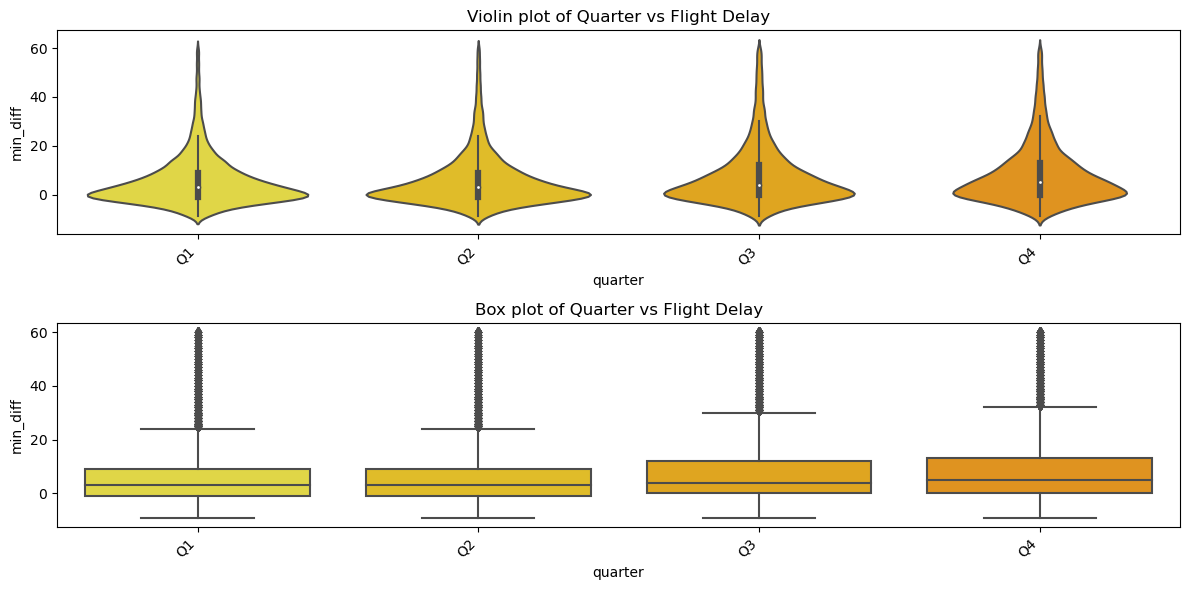

In [1187]:
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(211)
sns.violinplot(x="quarter", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax1.set_title('Violin plot of Quarter vs Flight Delay')
plt.xticks(rotation=45, ha='right')

ax2 = f.add_subplot(212)
sns.boxplot(x="quarter", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax2.set_title('Box plot of Quarter vs Flight Delay')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

#### <b> Delay vs Season </b>

In [1188]:
season_stats = df_wo_outliers["min_diff"].groupby(df_wo_outliers["high_season"]).apply(get_stats).unstack()
season_stats.sort_values("mean", ascending=False)

,min,max,count,mean,stddev
high_season,,,,,
1,-9.0,60.0,21691.0,7.205431,11.647969
0,-9.0,60.0,43413.0,6.696243,11.539429


In [1190]:
season_stats = df_wo_outliers["delay_15"].groupby(df_wo_outliers["high_season"]).apply(get_stats).unstack()
season_stats.sort_values("mean", ascending=False)

,min,max,count,mean,stddev
high_season,,,,,
1,0.0,1.0,21691.0,0.172744,0.378035
0,0.0,1.0,43413.0,0.158616,0.365322


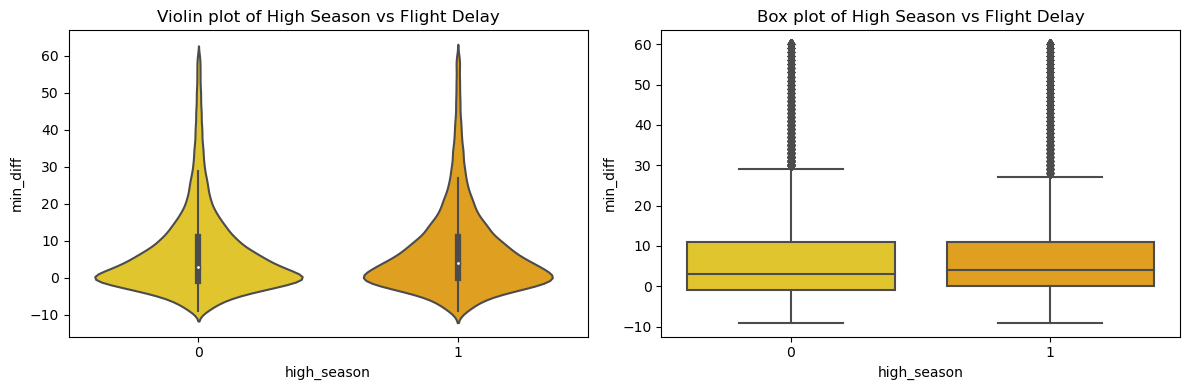

In [826]:
f = plt.figure(figsize=(12,4))

ax1 = f.add_subplot(121)
sns.violinplot(x="high_season", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax1.set_title('Violin plot of High Season vs Flight Delay')

ax2 = f.add_subplot(122)
sns.boxplot(x="high_season", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax2.set_title('Box plot of High Season vs Flight Delay')

plt.tight_layout()

## Delay vs Day of the week

In [827]:
weekday_stats = df_wo_outliers["min_diff"].groupby(df_wo_outliers["DIANOM"]).apply(get_stats).unstack()
weekday_stats.sort_values('mean', ascending=False)

,min,max,count,mean,stddev
DIANOM,,,,,
Viernes,-9.0,60.0,9801.0,8.112233,12.036435
Lunes,-9.0,60.0,9623.0,7.426478,12.156311
Jueves,-9.0,60.0,9809.0,7.392701,11.814133
Miercoles,-9.0,60.0,9287.0,6.501777,11.182053
Martes,-9.0,60.0,9244.0,6.274016,11.299618
Domingo,-9.0,60.0,9402.0,6.184535,11.245568
Sabado,-9.0,60.0,7938.0,5.918745,10.937696


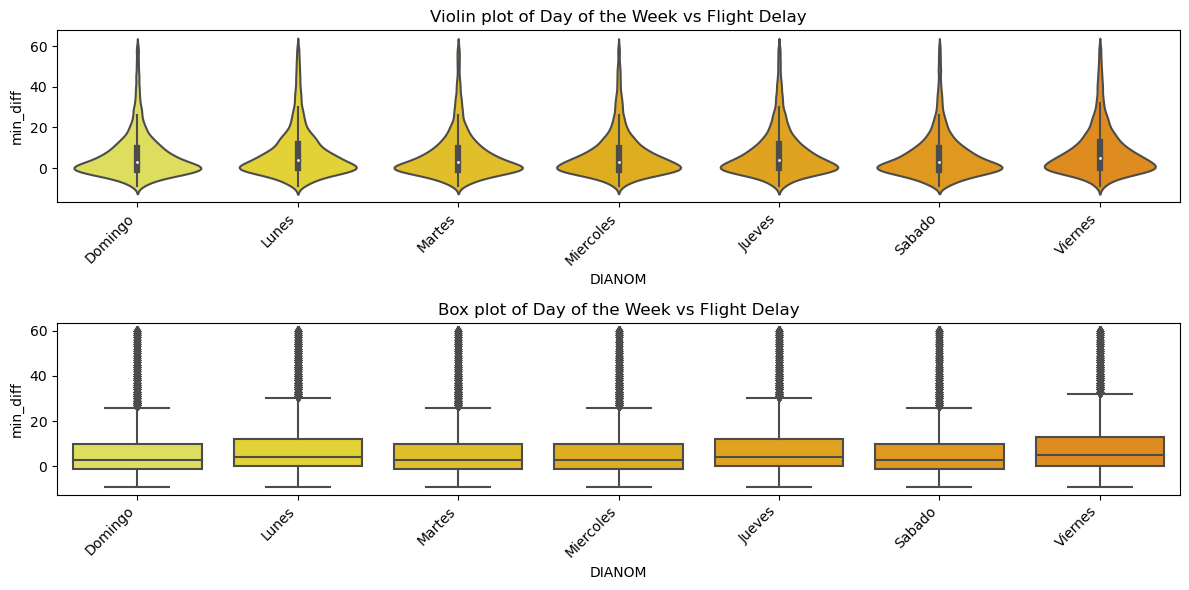

In [1191]:
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(211)
sns.violinplot(x="DIANOM", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax1.set_title('Violin plot of Day of the Week vs Flight Delay')
plt.xticks(rotation=45, ha='right')

ax2 = f.add_subplot(212)
sns.boxplot(x="DIANOM", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax2.set_title('Box plot of Day of the Week vs Flight Delay')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

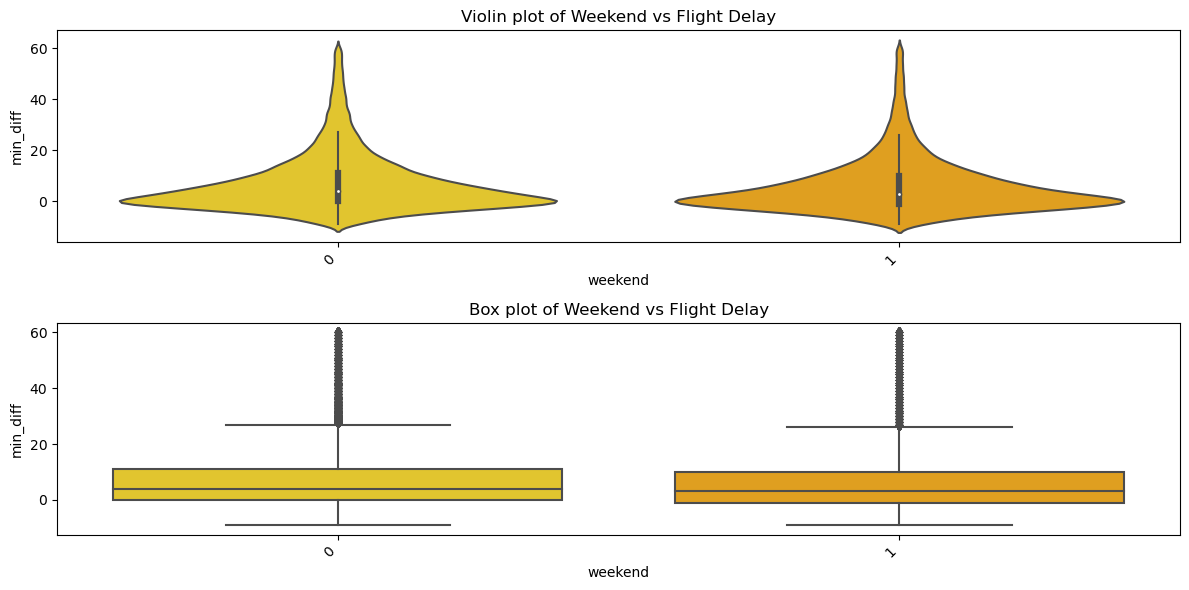

In [1194]:
# New feature to differentiate between weedays and weekend
# Even though is not that big of a difference. The days with lower delay mean were Saturday and Sunday. I'll use this new field of weekend to reduce dimensionality
df_wo_outliers["weekend"] = np.where((df_wo_outliers["DIANOM"] == 'Domingo') | (df_wo_outliers["DIANOM"] == 'Sabado'), 1, 0)

f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(211)
sns.violinplot(x="weekend", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax1.set_title('Violin plot of Weekend vs Flight Delay')
plt.xticks(rotation=45, ha='right')

ax2 = f.add_subplot(212)
sns.boxplot(x="weekend", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax2.set_title('Box plot of Weekend vs Flight Delay')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

In [1193]:
weekend_stats = df_wo_outliers["min_diff"].groupby(df_wo_outliers["weekend"]).apply(get_stats).unstack()
weekend_stats.sort_values("mean", ascending=False)

,min,max,count,mean,stddev
weekend,,,,,
0,-9.0,60.0,47764.0,7.15742,11.731265
1,-9.0,60.0,17340.0,6.06286,11.106159


#### <b> Delay vs Flight Type </b>

In [1195]:
flightype_stats = df_wo_outliers["min_diff"].groupby(df_wo_outliers["TIPOVUELO"]).apply(get_stats).unstack()
flightype_stats.sort_values("mean", ascending=False)

,min,max,count,mean,stddev
TIPOVUELO,,,,,
I,-9.0,60.0,29050.0,8.008606,12.709647
N,-9.0,60.0,36054.0,5.945166,10.488692


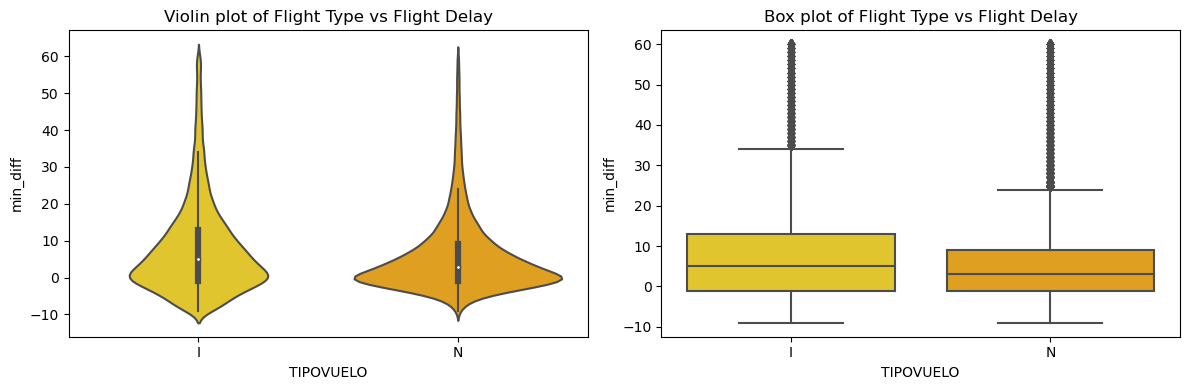

In [1196]:
f = plt.figure(figsize=(12,4))

ax1 = f.add_subplot(121)
sns.violinplot(x="TIPOVUELO", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax1.set_title('Violin plot of Flight Type vs Flight Delay')

ax2 = f.add_subplot(122)
sns.boxplot(x="TIPOVUELO", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax2.set_title('Box plot of Flight Type vs Flight Delay')

plt.tight_layout()

#### <b> Delay vs Period Day </b>

In [1197]:
periodday_stats = df_wo_outliers["min_diff"].groupby(df_wo_outliers["period_day"]).apply(get_stats).unstack()
periodday_stats.sort_values("mean", ascending=False)

,min,max,count,mean,stddev
period_day,,,,,
afternoon,-9.0,60.0,24600.0,7.527114,11.843413
night,-9.0,60.0,16138.0,7.001177,12.417534
morning,-9.0,60.0,24366.0,6.108717,10.649996


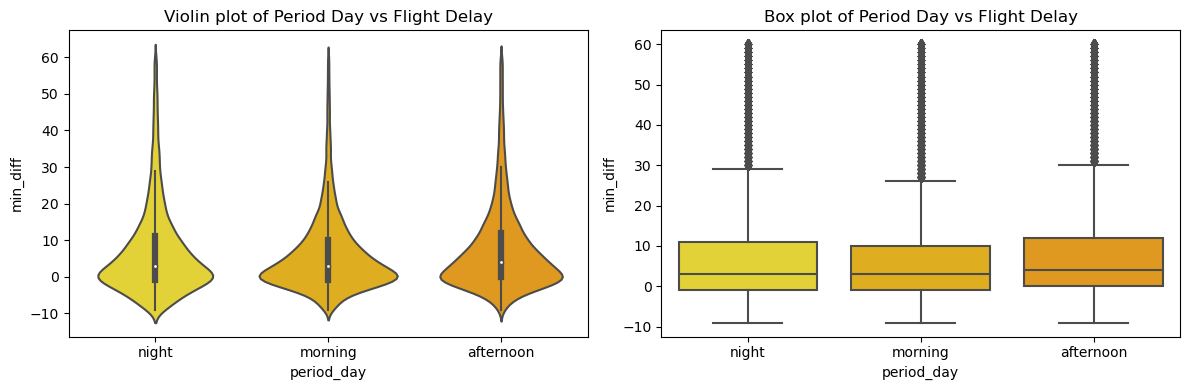

In [1198]:
f = plt.figure(figsize=(12,4))

ax1 = f.add_subplot(121)
sns.violinplot(x="period_day", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax1.set_title('Violin plot of Period Day vs Flight Delay')

ax2 = f.add_subplot(122)
sns.boxplot(x="period_day", y="min_diff", data=df_wo_outliers, palette='Wistia')
ax2.set_title('Box plot of Period Day vs Flight Delay')

plt.tight_layout()

#### <b> Delay vs Same Airlines </b>

In [1200]:
# New feature that reflects if the scheduled and operating airline are the same.
df_wo_outliers["same_airline"] = np.where(df_wo_outliers["Emp-I"] == df_wo_outliers["Emp-O"], 1, 0)

sameairline_stats = df_wo_outliers["delay_15"].groupby(df_wo_outliers["same_airline"]).apply(get_stats).unstack()
sameairline_stats.sort_values("mean", ascending=False)

,min,max,count,mean,stddev
same_airline,,,,,
1,0.0,1.0,47188.0,0.168051,0.373916
0,0.0,1.0,17916.0,0.150871,0.357933


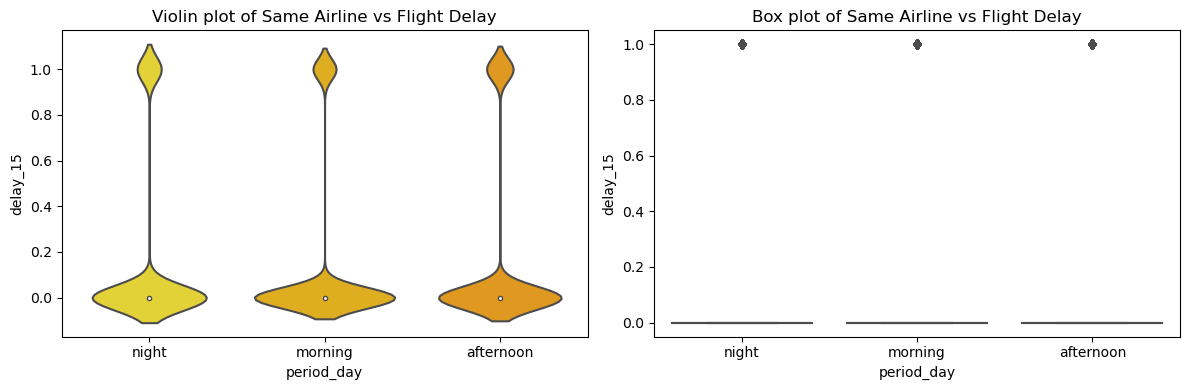

In [1201]:
f = plt.figure(figsize=(12,4))

ax1 = f.add_subplot(121)
sns.violinplot(x="period_day", y="delay_15", data=df_wo_outliers, palette='Wistia')
ax1.set_title('Violin plot of Same Airline vs Flight Delay')

ax2 = f.add_subplot(122)
sns.boxplot(x="period_day", y="delay_15", data=df_wo_outliers, palette='Wistia')
ax2.set_title('Box plot of Same Airline vs Flight Delay')

plt.tight_layout()

## <b> ANSWER </b>

The delay distribution is highly right skewed. No normal.
There aren't strong simple correlation between the features.

<b> Delay vs destination </b>  
There are definitely differences in the delay between destinations. After removing outliers we have data for 61 destinations but for the 15% lowest visited cities we have 30 or less data points (not enough to identify representative patterns or insights).  
Grouping the data by continent allow us to have more data per group. We can clearly see differences in the values and variability of the delay between continents, especially Oceania against the others.  
I expect this feature to be relevant in the predictive model.

<b> Delay vs airline </b>  
As expected, there are differences across airlines. Unfortunately, LATAM and Sky concentrates 80% of the data, so we have airlines with little data. Plus Ultra Lineas Aereas is the airline with highest delay mean but also the one with highest standard deviation and lowest data points.  
For reasons like the mentioned above and for dimensionality issues (we have data of 23 airlines), I decided to use the number of flights as a proxy for airline size and categorize the airlines as low, medium and high. There aren't clear differences in the delay rate between these categories. The high bucket has a higher mean but the standard deviations are quite elevated.  
I don't expect this feature to be strongly influencial in the predictions.

<b> Delay vs Month </b>  
As mentioned in the first questions, there are clear seasonal patterns. The delay mean is much higher in July and at the end of the year than in other months. March and April have the lowest delay mean.  
To reduce dimensions, I grouped the months in quarters where we are seeing more or less the same difference. Delay mean higher for the last 2 quarters.  
I expect this feature to be relevant in the predictive model.

<b> Delay vs Day of the week </b>  
There aren't much of a difference between the delay distribution across days of the week. What I'm seeing is that Saturday and Sunday are the days with lowest delays, so it could make sense to create a binary variable for the weekend.  
With the weekend feature the delay mean and distribution are still relatively similar.  
I don't expect this feature to be strongly influencial in the predictions.

<b> Delay vs Season </b>  
Delay mean and distribution are almost the same for both seasons.  
I don't expect this feature to be relevant in the predictive model.

<b> Delay vs Type of flight </b>  
There are clear differences in the distribution of the delay. International flights have higher overall delay rate and with more variability.  
I expect this feature to be relevant in the predictive model.

## <b> 4. Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay. Feel free to generate additional variables and/or supplement with external variables </b>

#### Note: I'll create a new variable called flight_delayed which will be 1 if the flight was delayed and 0 if not. I'll consider a flight as delayed if the delay in minutes is above 5 min.
#### Why 5 and not 15? We would have a highly imbalanced dataset if I consider 15 which will lead us having low number of positives. The median of the delay in minutes is 4, so I chose 5.

In [1202]:
# Creating the flight_delayed column

df_wo_outliers["flight_delayed"] = np.where(df_wo_outliers["min_diff"] > 5, 1, 0)

In [1203]:
# Encode categorical fields as dummies.

categorical_columns = ["Continent", "flights_count_bucket", "TIPOVUELO", "quarter", "period_day"]
encoded_df = pd.get_dummies(
    data = df_wo_outliers,
    prefix = 'dummy',
    prefix_sep='_',
    columns = categorical_columns,
    drop_first =True,
    dtype='int8'
)

In [1205]:
# Selecting our dependent and independent variables. Splitting the data into train and test

X = encoded_df.drop(columns=[
       "index", "Fecha-I", "Vlo-I", "Ori-I", "Des-I", "Emp-I", "Fecha-O", "Vlo-O", "Ori-O", "Des-O", "Emp-O",
       "DIA", "MES", "AÑO", "DIANOM", "OPERA", "SIGLAORI", "SIGLADES", "Country", "City",
       "min_diff", "delay_15", "boxcox_min_diff", "flight_delayed"
])

y = encoded_df["flight_delayed"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Logistic Regression

In [1206]:
# Training the Logistic Regression model and a Regression model with polynomial features (degree 2)

log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)
print(log_reg_model.score(X_train, y_train))

pol_2 = PolynomialFeatures(2)
X_train_pol = pol_2.fit_transform(X_train)

log_reg_model_pol = LogisticRegression()
log_reg_model_pol.fit(X_train_pol, y_train)
print(log_reg_model_pol.score(X_train_pol, y_train))

0.6112964100763627
0.624133239708593


/Users/ssotomayorba/miniconda3/envs/micromaster/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Decision Tree

In [1207]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))

0.6327569560256298


## <b> 5. Evaluate model performance in the predictive task across each model that you trained. Define and justify what metrics you used to assess model performance. Pick the best trained model and evaluate the following: What variables were the most influential in the prediction task? How could you improve the Performance? </b>

Since it is a well balanced dataset ROC AUC makes sense to use for evaluating the model performance. We can also complement this main metric with:
- Accuracy
- False Positives rate
- False Negatives rate
By having a better business understanding, we can also know if False Positives cost more than False Negatives or the other way around.

In [1208]:
# Dataset where I will store the performance metrics

performance = pd.DataFrame(index=["logistic_regression", "poly_logistic_regression", "decision_tree"], columns=["roc_auc_score", "accuracy", "false_positive_rate", "false_negative_rate"])

### Logistic Regression

In [1209]:

#Degree 1
y_prob = log_reg_model.predict_proba(X_test)
y_pred_binary = log_reg_model.predict(X_test)
roc_auc_log = roc_auc_score(y_test, y_prob[:, 1])
performance.loc["logistic_regression", "roc_auc_score"] = roc_auc_log

#Polynomial
pol_2_test = PolynomialFeatures(2)
X_test_pol = pol_2_test.fit_transform(X_test)

y_pred_pol = log_reg_model_pol.predict_proba(X_test_pol)
y_pred_pol_binary = log_reg_model_pol.predict(X_test_pol)
roc_auc_score_pol = roc_auc_score(y_test, y_pred_pol[:, 1])
performance.loc["poly_logistic_regression", "roc_auc_score"] = roc_auc_score_pol

In [1210]:
# Degree 1

cm_log = confusion_matrix(y_test, y_pred_binary)
TP_log = cm_log[0][0]
TN_log = cm_log[1][1]
FN_log = cm_log[1][0]
FP_log = cm_log[0][1]
fp_rate_log = FP_log/(FP_log + TN_log)
fn_rate_log = FN_log/(FN_log + TP_log)
accuracy_log = (TP_log + TN_log)/(TP_log + TN_log + FP_log + FN_log)

performance.loc["logistic_regression", "accuracy"] = accuracy_log
performance.loc["logistic_regression", "false_positive_rate"] = fp_rate_log
performance.loc["logistic_regression", "false_negative_rate"] = fn_rate_log

In [1211]:
# Degree 2

cm_log_pol = confusion_matrix(y_test, y_pred_pol_binary)
TP_log_pol = cm_log_pol[0][0]
TN_log_pol = cm_log_pol[1][1]
FN_log_pol = cm_log_pol[1][0]
FP_log_pol = cm_log_pol[0][1]
fp_rate_log_pol = FP_log_pol/(FP_log_pol + TN_log_pol)
fn_rate_log_pol = FN_log_pol/(FN_log_pol + TP_log_pol)
accuracy_log_pol = (TP_log_pol + TN_log_pol)/(TP_log_pol + TN_log_pol + FP_log_pol + FN_log_pol)

performance.loc["poly_logistic_regression", "accuracy"] = accuracy_log_pol
performance.loc["poly_logistic_regression", "false_positive_rate"] = fp_rate_log_pol
performance.loc["poly_logistic_regression", "false_negative_rate"] = fn_rate_log_pol

### Decision Tree

In [1212]:
y_pred_tree = clf.predict_proba(X_test)
y_pred_tree_binary = clf.predict(X_test)
roc_auc_score_tree = roc_auc_score(y_test, y_pred_tree[:, 1])
performance.loc["decision_tree", "roc_auc_score"] = roc_auc_score_tree

In [1213]:
cm_tree = confusion_matrix(y_test, y_pred_tree_binary)
TP_tree = cm_tree[0][0]
TN_tree = cm_tree[1][1]
FN_tree = cm_tree[1][0]
FP_tree = cm_tree[0][1]
fp_rate_tree = FP_tree/(FP_tree + TN_tree)
fn_rate_tree = FN_tree/(FN_tree + TP_tree)
accuracy_tree = (TP_tree + TN_tree)/(TP_tree + TN_tree + FP_tree + FN_tree)

performance.loc["decision_tree", "accuracy"] = accuracy_tree
performance.loc["decision_tree", "false_positive_rate"] = fp_rate_tree
performance.loc["decision_tree", "false_negative_rate"] = fn_rate_tree

In [1214]:
performance


,roc_auc_score,accuracy,false_positive_rate,false_negative_rate
logistic_regression,0.620918,0.604188,0.456306,0.379069
poly_logistic_regression,0.6403,0.613813,0.453453,0.356404
decision_tree,0.640647,0.618319,0.445421,0.353974


#### The Polynomial Logistic Regression and Decision Tree achieved very similar results in terms of performance.  
#### I will pick the Decision Tree as best model as it does not use polynomial features so the model can be better explained, accepted and understood by non-technical people.

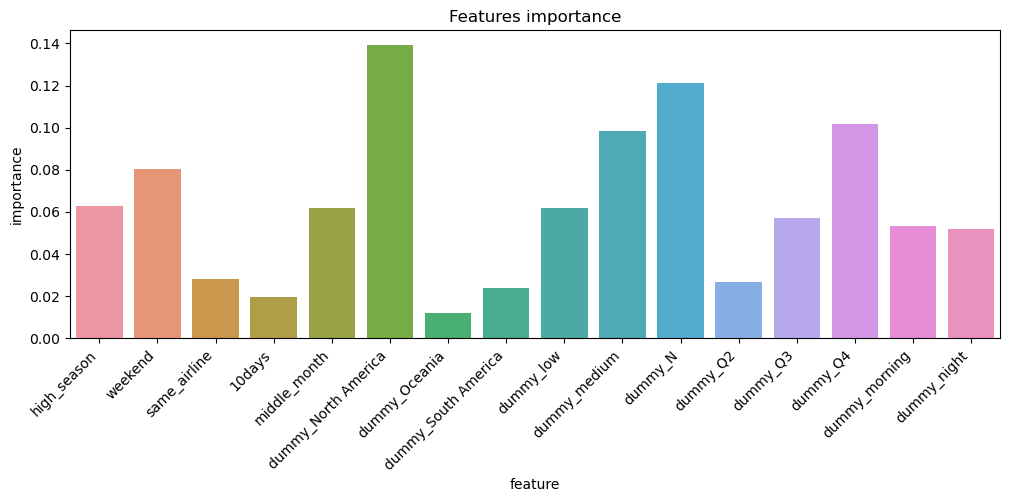

In [1117]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = X.columns
feature_importance["importance"] = clf.feature_importances_

f = plt.figure(figsize=(12,4))

ax1 = f.add_subplot(111)
sns.barplot(x=feature_importance["feature"], y=feature_importance["importance"])
ax1.set_title('Features importance')
plt.xticks(rotation=45, ha='right')

plt.show()

#### The most influential variables are North America dummy variable (from Destination), National flights dummy variable (from Flight Type), Q4 dummy variable (from Month) and medium dummy variable (from airline size proxy).

#### To improve model performance I would add new features to the model like:
#### - Weather variables
#### - If the airplane comes from another flight. If yes, from where.
#### - Use flights not just from Santiago but from other airports as well and include the origin as part of the variables. Have more data, we can get closer to a normal distribution and have a wider variety of tests to try.